# Exploring potential impact of BERT embeddings

Here we visualise BERT embeddings to anticipate how effective they might as input data to a sentiment classifier.

The goal is to find some separation between our positive and negagtive labels with the following steps:

1. load the reviews.
2. extract a document embedding for each review using a pretrained BERT model.
3. use UMAP to reduce dimensions to 2 for plotting.

If we don't see any discriminative potential for these embeddings then there might be an argument to use simpler training data such as a bag-of-words approach.

## Load the reviews

In [ ]:
# download dataset if needed
#download_data("https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz")

In [2]:
from data import get_train_data_as_csv

# read in training data keeping a random state for reproducibility
df_reviews = get_train_data_as_csv().sample(n=2000, random_state=42)

# encode labels
labels = dict(neg=0, pos=1)
df_reviews['label'] = df_reviews['sentiment'].map(labels)

# print opening lines
df_reviews.head()

INFO:root:Reading data into pandas DataFrame
INFO:root:Read complete


,review,sentiment,label
6868,You know how Star Trek fans flocked to all the...,pos,1
24016,I am quite a fan of novelist/screenwriter Mich...,neg,0
9668,"Well, if you are one of those Katana's film-nu...",pos,1
13640,This star-studded British/Spanish co-productio...,neg,0
14018,When Stanwyck's husband-to-be is murdered on t...,neg,0


In [3]:
df_reviews.shape

(2000, 3)

## Extract BERT embeddings

For this we will use the distilled version as it keeps most of the full model's performance at a fraction of the size.

In [1]:
# tokenize
import numpy as np
import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModel
from transformers import pipeline


tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
model = TFAutoModel.from_pretrained('distilbert-base-uncased')

2024-07-07 13:25:23.028640: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-07 13:25:23.418102: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-07 13:25:24.665070: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/otsapp/projects/review-sentiment-analysis/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .auto

In [4]:
# embedding

from embedding import get_document_embeddings

doc_embeddings = get_document_embeddings(df_reviews['review'].tolist())

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['classifier.weight', 'pre_classifier.bias', 'classifier.bias', 'pre_classifier.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.
Token indices sequence length is longer than the specified maximum sequence length for this model (949 > 512). Ru

AttributeError: 'list' object has no attribute 'shape'

In [6]:
np.array(doc_embeddings).shape

(2000, 768)

# Reduce dimensionality with UMAP & plot

- While we might lose some information during dimensionality reduction, we can still see there are distinct areas dominated by positive or negative reviews.
- This should be enough for us to try BERT embeddings in our model development phase.

/home/otsapp/projects/review-sentiment-analysis/.venv/lib/python3.12/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
/home/otsapp/projects/review-sentiment-analysis/.venv/lib/python3.12/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/home/otsapp/projects/review-sentiment-analysis/.venv/lib/python3.12/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (co

<Axes: >

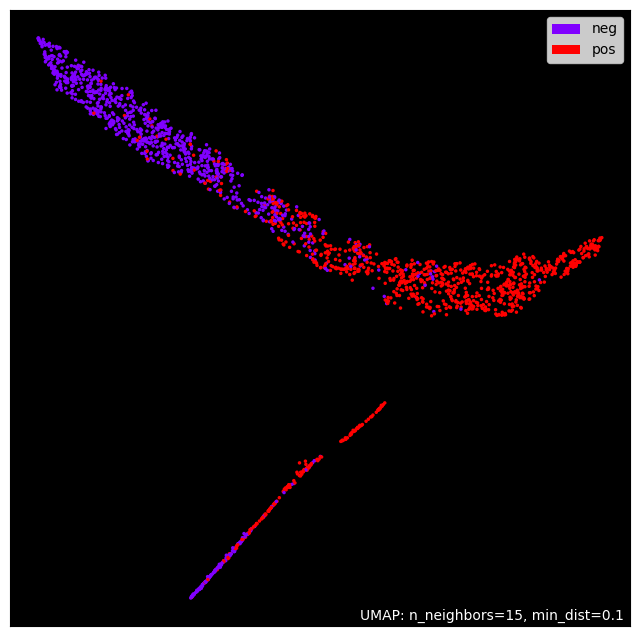

In [7]:
import umap
import umap.plot

# labels
mapper = umap.UMAP().fit(np.array(doc_embeddings))
umap.plot.points(mapper, labels=df_reviews['sentiment'], theme='fire')

## Connectivity

If we explore the relationships between the points we can see there are connections that link the large cluster with the long thin one. While UMAP's process to preserve local structure has created separation, the connections betray underlying similarities. It's also reassuring to see that the points connecting the two clusters tend be from the same sentiment.

<Axes: >

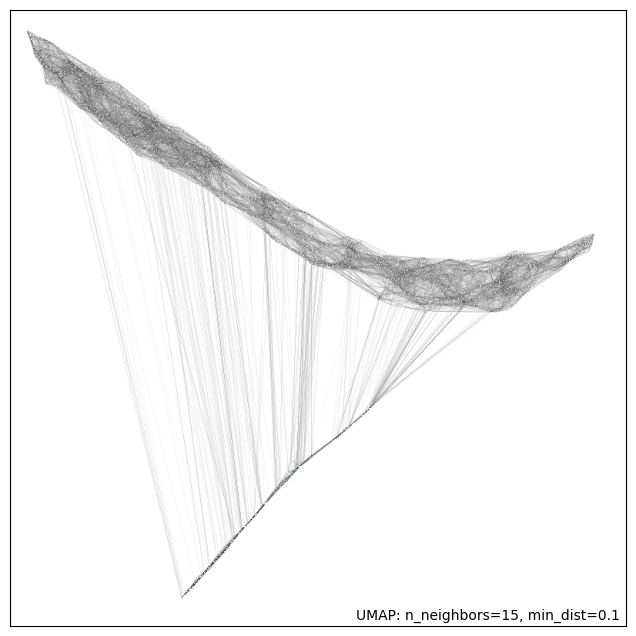

In [8]:
umap.plot.connectivity(mapper, show_points=True)

## Edge bundling

- Although we got a good idea of connectivity with the visual above, we can improve clarity a step further. 
- This doesn't tell us anything new in terms of whether we should use BERT embeddings or not.

/home/otsapp/projects/review-sentiment-analysis/.venv/lib/python3.12/site-packages/umap/plot.py:894: UserWarning: Hammer edge bundling is expensive for large graphs!
This may take a long time to compute!
  warn(


<Axes: >

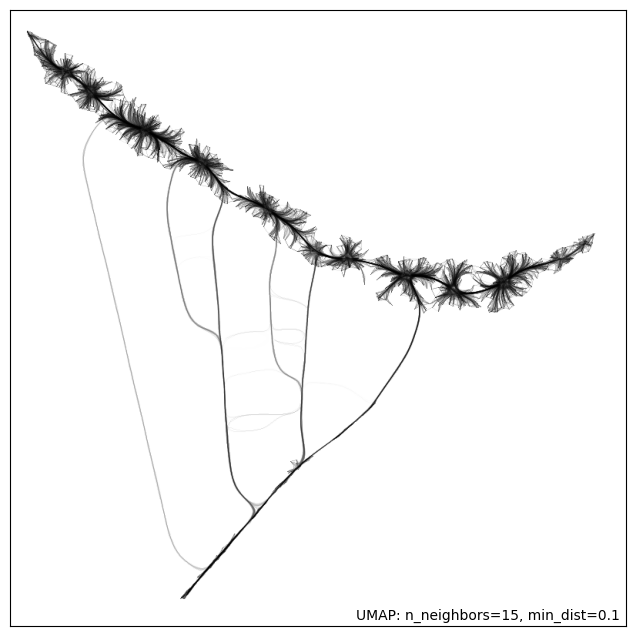

In [9]:
umap.plot.connectivity(mapper, edge_bundling='hammer')